<a href="https://colab.research.google.com/github/MHzNug/Capstone-Project/blob/main/Model%20Klasifikasi%20Padi/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===📦 Paket bawaan===
import os
import random
import shutil

# ===📊 Data dan visualisasi===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===🖼️ Pemrosesan gambar===
from PIL import Image
import cv2

# ===🤖 TensorFlow & Keras===
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D,
    Dense, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
)
from tensorflow.keras import Input
from keras.layers import TFSMLayer

# ===🧪 Utilities===
from sklearn.model_selection import train_test_split

# ===🌐 Kaggle Hub===
import kagglehub

In [2]:
path = kagglehub.dataset_download("loki4514/rice-leaf-diseases-detection")

print("Path to dataset files:", path)

100%|██████████| 8.03G/8.03G [06:19<00:00, 22.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/loki4514/rice-leaf-diseases-detection/versions/8


In [3]:
os.listdir(path)

['Rice_Leaf_Diease', 'Rice_Leaf_AUG']

In [4]:
os.listdir(os.path.join(path, 'Rice_Leaf_Diease', 'Rice_Leaf_Diease'))

['test', 'train']

In [5]:
train_folder = os.path.join(path, 'Rice_Leaf_Diease', 'Rice_Leaf_Diease', 'train')
test_folder = os.path.join(path, 'Rice_Leaf_Diease', 'Rice_Leaf_Diease', 'test')

class_names = os.listdir(train_folder)
print(class_names)

['leaf_blast', 'rice_hispa', 'leaf_scald', 'neck_blast', 'narrow_brown_spot', 'sheath_blight', 'healthy', 'bacterial_leaf_blight', 'brown_spot', 'tungro']


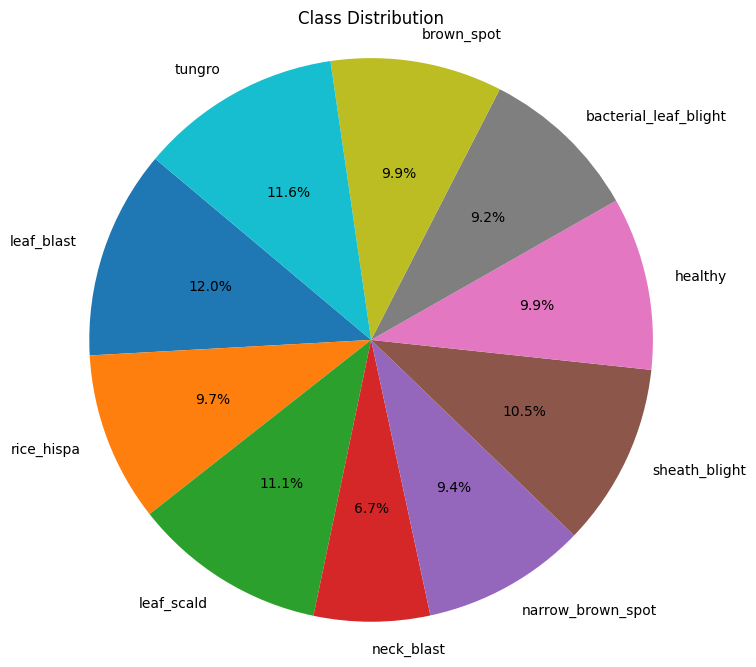

In [6]:
class_counts = []
for class_name in class_names:
    class_counts.append(len(os.listdir(os.path.join(train_folder, class_name))))

plt.figure(figsize=(8, 8))
plt.pie(class_counts, labels=class_names, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

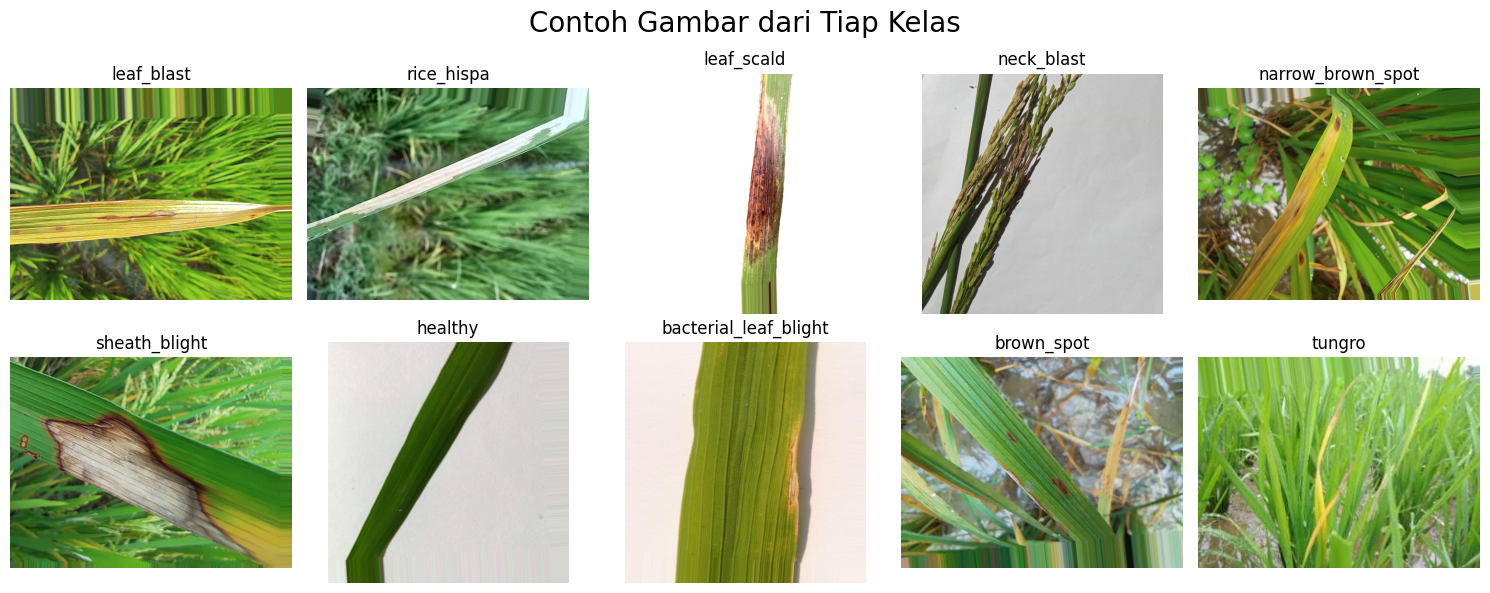

In [7]:
n_classes = len(class_names)
n_rows = 2
n_cols = int(np.ceil(n_classes / n_rows))

fig, axs = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axs = axs.flatten()  # ubah ke 1D array supaya mudah di-loop

for ax, class_name in zip(axs, class_names):
    image_paths = []
    for folder in [train_folder]:
        path = os.path.join(folder, class_name)
        if os.path.exists(path):
            image_paths += [os.path.join(path, img) for img in os.listdir(path)]

    if image_paths:
        img = cv2.cvtColor(cv2.imread(random.choice(image_paths)), cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(class_name)
    ax.axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas", fontsize=20)
plt.tight_layout()
plt.show()

In [8]:
base_dir = 'dataset'

for split in ['train', 'val', 'test']:
    for class_name in class_names:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

for class_name in class_names:
    class_train_path = os.path.join(train_folder, class_name)
    class_test_path = os.path.join(test_folder, class_name)

    train_image_paths = []
    test_image_paths = []

    if os.path.exists(class_train_path):
        train_files = [f for f in os.listdir(class_train_path)
                     if os.path.isfile(os.path.join(class_train_path, f))]
        train_image_paths = [os.path.join(class_train_path, f) for f in train_files]

    if os.path.exists(class_test_path):
        test_files = [f for f in os.listdir(class_test_path)
                    if os.path.isfile(os.path.join(class_test_path, f))]
        test_image_paths = [os.path.join(class_test_path, f) for f in test_files]

    if test_image_paths:
        train_images, val_images = train_test_split(train_image_paths, test_size=0.2, random_state=42)
    else:
        val_images = []
        train_images = []

    for img_path in train_images:
        dst = os.path.join(base_dir, 'train', class_name, os.path.basename(img_path))
        shutil.copy(img_path, dst)

    for img_path in val_images:
        dst = os.path.join(base_dir, 'val', class_name, os.path.basename(img_path))
        shutil.copy(img_path, dst)

    for img_path in test_image_paths:
        dst = os.path.join(base_dir, 'test', class_name, os.path.basename(img_path))
        shutil.copy(img_path, dst)

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 7392 images belonging to 10 classes.
Found 2277 images belonging to 10 classes.
Found 1852 images belonging to 10 classes.


In [10]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, acc_threshold=0.95, val_acc_threshold=0.95):
        super(StopTrainingAtAccuracy, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.acc_threshold and val_acc >= self.val_acc_threshold:
                print(f"\n Target tercapai! Akurasi dan val_akurasi >= {self.acc_threshold * 100:.0f}%")
                self.model.stop_training = True

In [11]:
model = Sequential([
    InputLayer(input_shape=(150, 150, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [12]:
callback = [
    StopTrainingAtAccuracy(),
    ModelCheckpoint('model_checkpoint.keras', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
]

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callback,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.3100 - loss: 1.6923
Epoch 1: val_loss improved from inf to 1.21514, saving model to model_checkpoint.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 137s 565ms/step - accuracy: 0.3105 - loss: 1.6912 - val_accuracy: 0.5686 - val_loss: 1.2151
Epoch 2/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - accuracy: 0.6110 - loss: 1.0366
Epoch 2: val_loss improved from 1.21514 to 0.71559, saving model to model_checkpoint.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 124s 535ms/step - accuracy: 0.6111 - loss: 1.0363 - val_accuracy: 0.7343 - val_loss: 0.7156
Epoch 3/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.7074 - loss: 0.7777
Epoch 3: val_loss improved from 0.71559 to 0.65743, saving model to model_checkpoint.keras
231/231 ━━━━━━━━━━━━━━━━━━━━ 122s 527ms/step - accuracy: 0.7074 - loss: 0.7777 - val_accuracy: 0.7597 - val_loss: 0.6574
Epoch 4/50
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - accuracy: 0.7423 - loss: 0.6727
Epoch 4: val_los

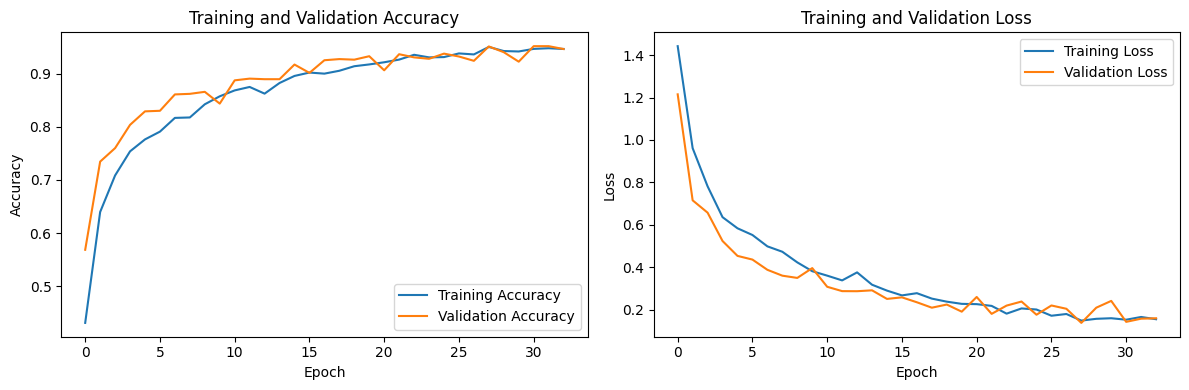

In [13]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 379ms/step - accuracy: 0.9626 - loss: 0.1332
Test Loss: 0.1291, Test Accuracy: 0.9640


In [15]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.34.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [16]:
model.save("/content/my_model.keras")

In [17]:
model.save("/content/my_model.h5")

In [18]:
!tensorflowjs_converter \
    --input_format=keras \
    my_model.h5 \
    tfjs_model/

2025-06-11 16:15:55.060217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749658555.082126   22265 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749658555.088948   22265 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [19]:
from google.colab import files

!zip -r tfjs_model.zip tfjs_model
files.download("tfjs_model.zip")

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard4of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard1of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard3of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard2of6.bin (deflated 7%)
  adding: tfjs_model/model.json (deflated 86%)
  adding: tfjs_model/group1-shard5of6.bin (deflated 7%)
  adding: tfjs_model/group1-shard6of6.bin (deflated 7%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
# SavedModel (untuk TFLite & TFJS)
model.export('/content//saved_model')

# TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('/content/saved_model')
tflite_model = converter.convert()
with open('/content/model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/content//saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132501077793040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077794000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077792848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077796880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077796112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077797840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077797264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077798224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077798608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132501077800144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13250107

In [21]:
!zip -r saved_model.zip saved_model
files.download("saved_model.zip")

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 63%)
  adding: saved_model/saved_model.pb (deflated 86%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>